# IA-NAHA — Notebook visuel  en vu du codage de l'IA et Machine Learning appliqués au sport et à la nutrition

---

**Projet :** IA-NAHA est un projet visant à explorer comment l'Intelligence Artificielle peut agir comme un coach virtuel intelligent pour les individus.

**Objectif :** Développer un modèle de Machine Learning capable de prédire la qualité et la durée du sommeil d'un utilisateur en analysant ses données biométriques quotidiennes.

**Problématique :** *Comment l'IA peut-elle agir comme un coach virtuel pour prédire le sommeil d'un individu, puis anticiper ses besoins journaliers ?*

**Méthodes :** Machine Learning, analyse de données biométriques, modélisation prédictive.

---

## 0. Chargement des données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df_logs = pd.read_csv('sommeil_logs.csv', sep=';')
df_profils = pd.read_csv('profil_utilisateur.csv', sep=';')
df = pd.merge(df_logs, df_profils, on='id_profil')

if 'blood_pressure' in df.columns:
    df[['Systolic_BP', 'Diastolic_BP']] = df['blood_pressure'].str.split('/', expand=True).astype(float)

sns.set_theme(style='whitegrid', palette='Set2')
print(f"Dataset : {df.shape[0]} observations, {df.shape[1]} variables")
df.head()

Dataset : 5000 observations, 17 variables


,id_person,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,blood_pressure,heart_rate,daily_steps,sleep_disorder,id_profil,tranche_age,genre,categorie_imc,Systolic_BP,Diastolic_BP
0,1,27,Software Engineer,6.1,6,42,6,126/83,77,4200,NaN,1,<30 ans,Male,Overweight,126.0,83.0
1,2,28,Doctor,6.2,6,60,8,125/80,75,10000,NaN,2,<30 ans,Male,Normal,125.0,80.0
2,3,28,Doctor,6.2,6,60,8,125/80,75,10000,NaN,2,<30 ans,Male,Normal,125.0,80.0
3,4,28,Sales Representative,5.9,4,30,8,140/90,85,3000,Sleep Apnea,3,<30 ans,Male,Obese,140.0,90.0
4,5,28,Sales Representative,5.9,4,30,8,140/90,85,3000,Sleep Apnea,3,<30 ans,Male,Obese,140.0,90.0


---
## 1. Comment dort notre population ?

Commençons par observer la distribution brute de la durée de sommeil.

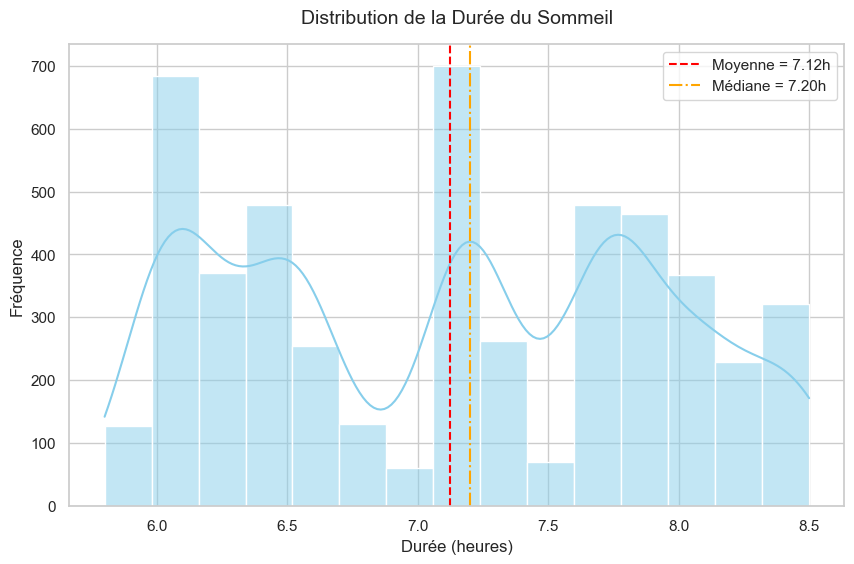

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sleep_duration'], kde=True, bins=15, color='skyblue', edgecolor='white')
plt.axvline(df['sleep_duration'].mean(), color='red', linestyle='--', label=f"Moyenne = {df['sleep_duration'].mean():.2f}h")
plt.axvline(df['sleep_duration'].median(), color='orange', linestyle='-.', label=f"Médiane = {df['sleep_duration'].median():.2f}h")
plt.legend(fontsize=11)
plt.title('Distribution de la Durée du Sommeil', fontsize=14, pad=15)
plt.xlabel('Durée (heures)')
plt.ylabel('Fréquence')
plt.show()

**Interprétation :** La durée de sommeil suit une distribution légèrement asymétrique, centrée autour de 7h. La majorité des individus dorment entre 6 et 8 heures, avec quelques extrêmes de chaque côté.

---
## 2. Vue d'ensemble : quelles variables sont corrélées ?

La matrice de corrélation donne une carte thermique des relations entre toutes les variables numériques.

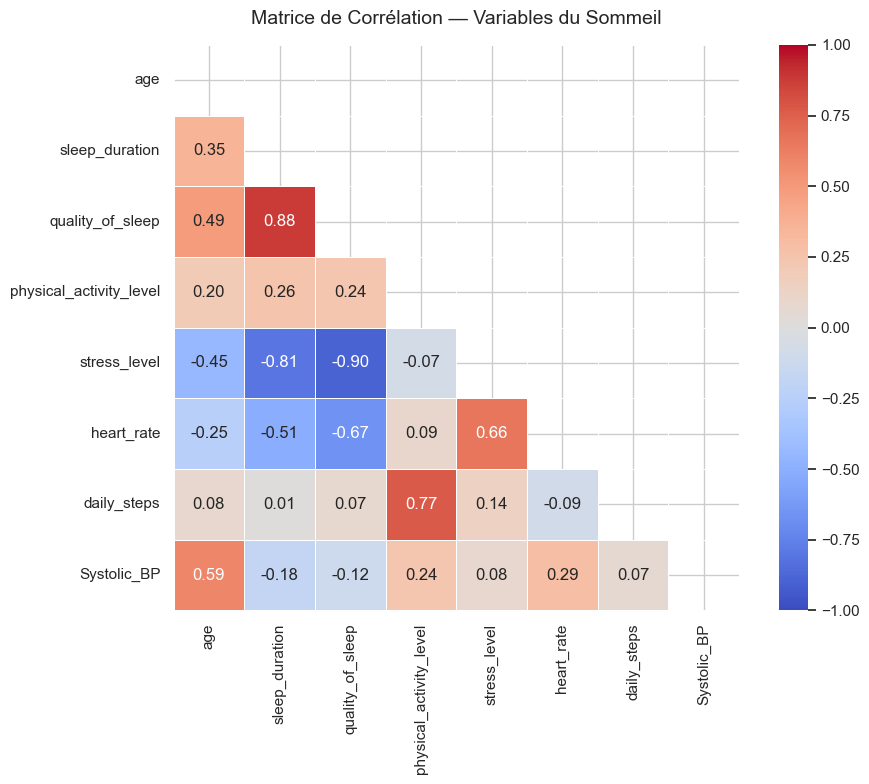

In [ ]:
cols = ['age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level',
        'stress_level', 'heart_rate', 'daily_steps', 'Systolic_BP']
corr = df[cols].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Matrice de Corrélation — Variables du Sommeil', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

**Interprétation :** Le stress et le rythme cardiaque apparaissent comme les variables les plus corrélées (négativement) à la durée du sommeil. L'activité physique montre une corrélation positive mais plus faible et le sommeil est un phénomène qui s'explique de différentes manières.

---
## 3. Le stress, ennemi du sommeil ?

### 3.1 Stress vs Qualité du sommeil

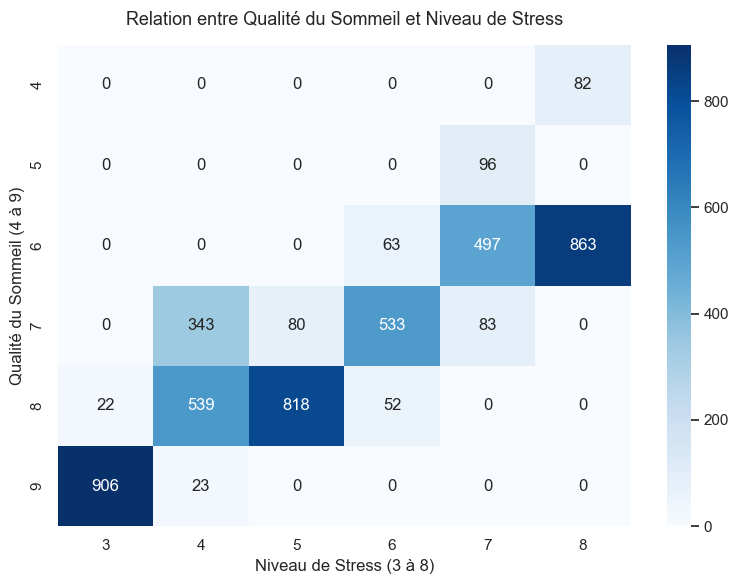

In [ ]:
contingency_table = pd.crosstab(df['quality_of_sleep'], df['stress_level'])

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Relation entre Qualité du Sommeil et Niveau de Stress', fontsize=13, pad=15)
plt.xlabel('Niveau de Stress (3 à 8)')
plt.ylabel('Qualité du Sommeil (4 à 9)')
plt.tight_layout()
plt.show()



**Interprétation :** La diagonale inversée est très nette : les individus peu stressés (3-4) ont une qualité de sommeil élevée (8-9), et inversement.

### 3.2 Stress vs Durée du sommeil

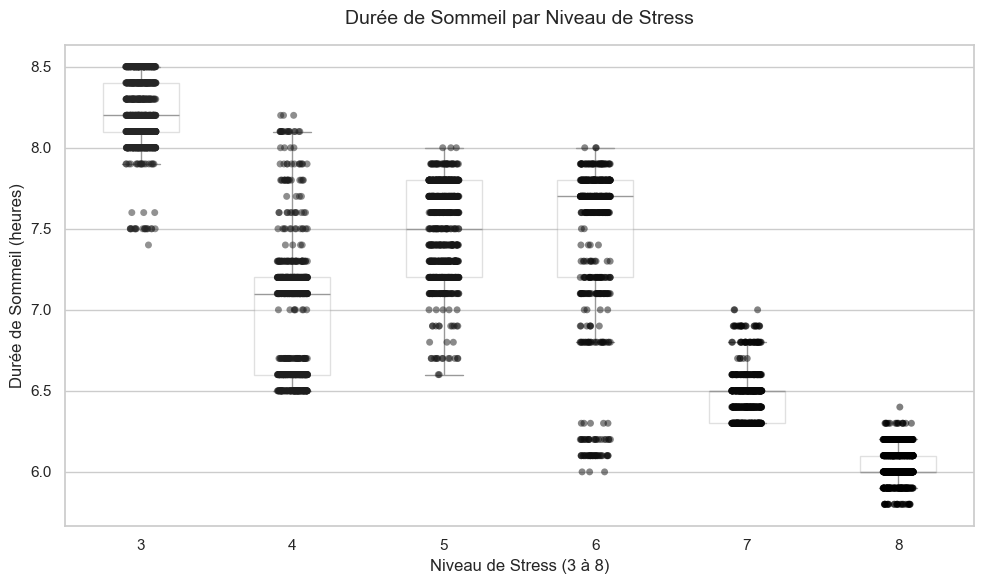

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='stress_level', y='sleep_duration',
              palette='dark:black',hue='stress_level', alpha=0.5,legend=False, jitter=True)
sns.boxplot(data=df, x='stress_level', y='sleep_duration',
            color='white', width=0.5, fliersize=0, boxprops=dict(alpha=0.3))
plt.title('Durée de Sommeil par Niveau de Stress', fontsize=14, pad=15)
plt.xlabel('Niveau de Stress (3 à 8)')
plt.ylabel('Durée de Sommeil (heures)')
plt.tight_layout()
plt.show()



**Interprétation :** Plus le stress augmente, plus la médiane de sommeil baisse nettement.Les différences entre groupes de stress sont hautement significatives donc le stress est bien le facteur le plus impactant sur la durée de sommeil.

---
## 4. L'activité physique aide-t-elle à mieux dormir ?

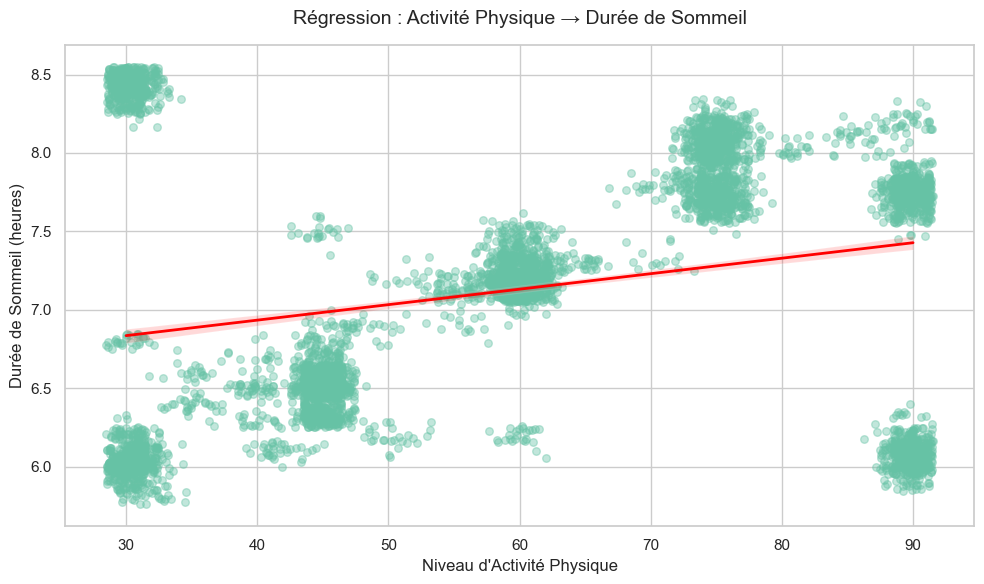

R² = 0.066


In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='physical_activity_level', y='sleep_duration',
            x_jitter=1.5, y_jitter=0.05,
            scatter_kws={'alpha': 0.4, 's': 30},
            line_kws={'color': 'red', 'linewidth': 2})
plt.title("Régression : Activité Physique → Durée de Sommeil", fontsize=14, pad=15)
plt.xlabel("Niveau d'Activité Physique")
plt.ylabel('Durée de Sommeil (heures)')
plt.tight_layout()
plt.show()

model = smf.ols('sleep_duration ~ physical_activity_level', data=df).fit()
print(f"R² = {model.rsquared:.3f}")

**Interprétation :** La pente est positive mais faible (R² ≈ 0.07) : l'activité physique est bien associée à un sommeil plus long, mais n'en explique qu'une petite fraction. Bouger aide, mais ce n'est pas le facteur déterminant.

---
## 5. Le métier influence-t-il nos nuits ?

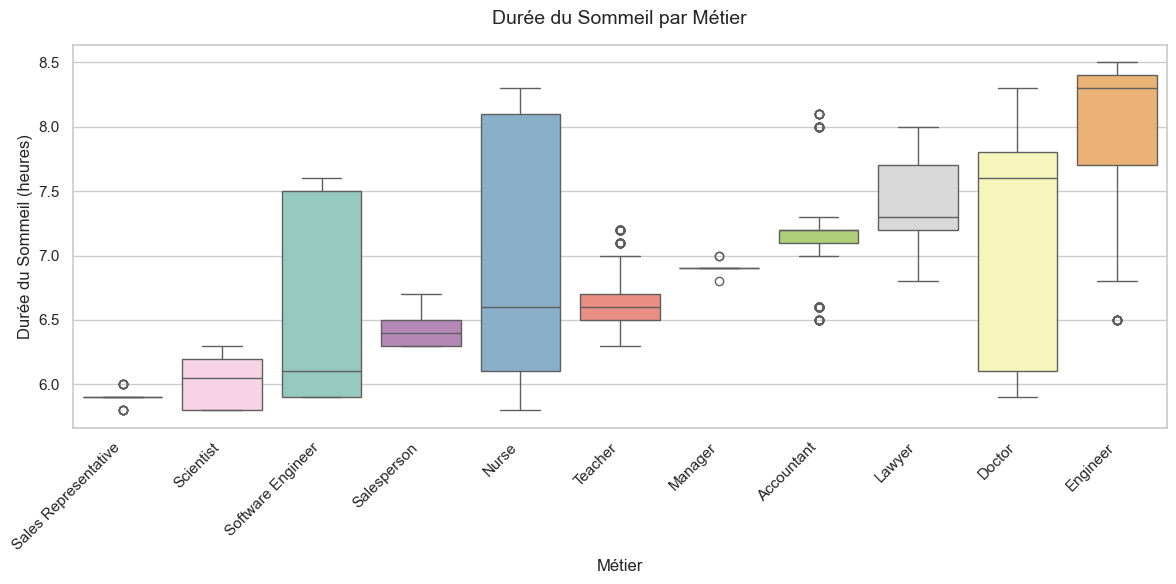

In [ ]:
plt.figure(figsize=(12, 6))
ordre_metiers = df.groupby('occupation')['sleep_duration'].median().sort_values().index
sns.boxplot(data=df, x='occupation', y='sleep_duration',hue='occupation', legend=False,
            order=ordre_metiers, palette='Set3')
plt.title('Durée du Sommeil par Métier', fontsize=14, pad=15)
plt.xlabel('Métier')
plt.ylabel('Durée du Sommeil (heures)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



**Interprétation :** Les métiers ne sont pas égaux face au sommeil. Certaines professions (à gauche) affichent des médianes nettement plus basses, probablement liées au stress ou aux horaires atypiques.

---
## 6. Le cœur parle aussi : rythme cardiaque et sommeil

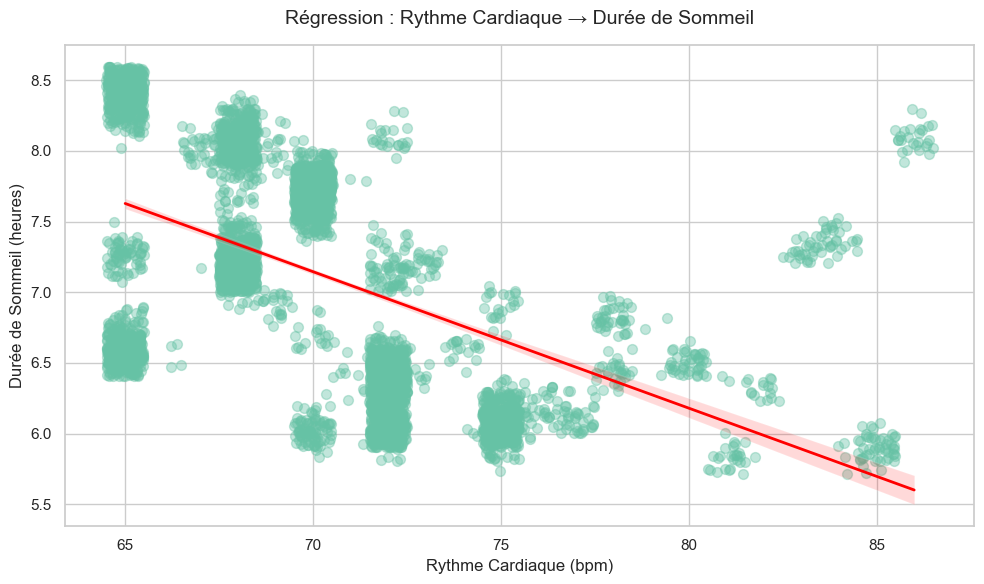

Corrélation de Pearson : r = -0.513


In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='heart_rate', y='sleep_duration',
            x_jitter=0.5, y_jitter=0.1,
            scatter_kws={'alpha': 0.4, 's': 50},
            line_kws={'color': 'red', 'linewidth': 2})
plt.title('Régression : Rythme Cardiaque → Durée de Sommeil', fontsize=14, pad=15)
plt.xlabel('Rythme Cardiaque (bpm)')
plt.ylabel('Durée de Sommeil (heures)')
plt.tight_layout()
plt.show()

r, p = pearsonr(df['heart_rate'], df['sleep_duration'])
print(f"Corrélation de Pearson : r = {r:+.3f}")

**Interprétation :** La droite de régression descend clairement : plus le rythme cardiaque est élevé, moins on dort. Un cœur au repos lent (signe de bonne forme cardiovasculaire) est associé à un sommeil plus long.

---
## 7. Tension artérielle et sommeil

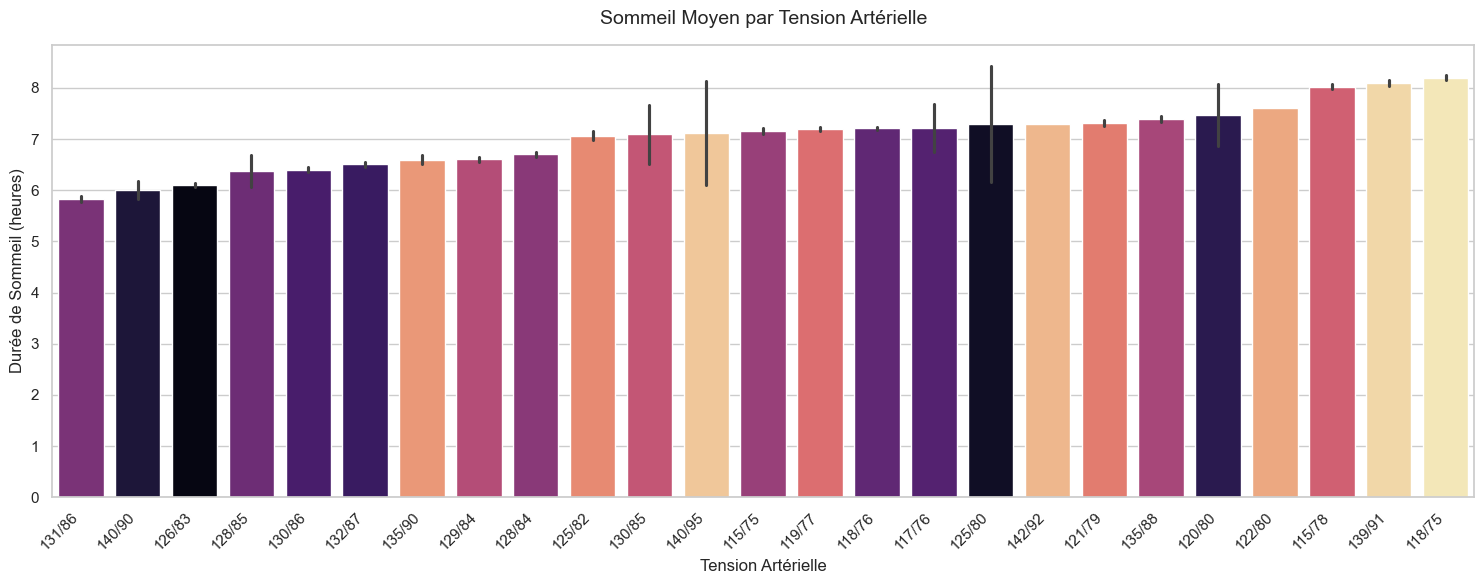

Corrélation pression systolique / sommeil : r = -0.179, p = 3.80e-37<0.05


In [ ]:
plt.figure(figsize=(15, 6))
ordre_bp = df.groupby('blood_pressure')['sleep_duration'].mean().sort_values().index
sns.barplot(x='blood_pressure', y='sleep_duration', data=df,hue='blood_pressure',legend=False,
            order=ordre_bp, palette='magma', errorbar='sd')
plt.title('Sommeil Moyen par Tension Artérielle', fontsize=14, pad=15)
plt.xlabel('Tension Artérielle')
plt.ylabel('Durée de Sommeil (heures)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

r, p = pearsonr(df['Systolic_BP'], df['sleep_duration'])
print(f"Corrélation pression systolique / sommeil : r = {r:+.3f}, p = {p:.2e}<0.05")

**Interprétation :** Les personnes avec une tension plus élevée dorment en moyenne moins longtemps. Les barres d'erreur montrent une forte variabilité, mais la tendance générale confirme le lien entre santé cardiovasculaire et qualité du sommeil au risque de 5%.

---
## 8. La corpulence joue-t-elle un rôle ?

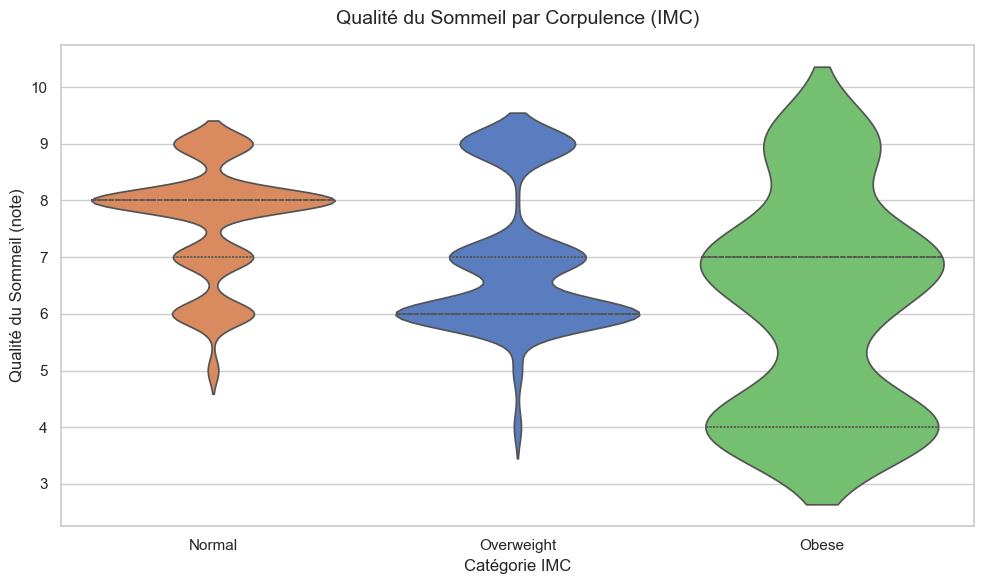

In [ ]:
plt.figure(figsize=(10, 6))
ordre_imc = ['Normal', 'Overweight', 'Obese']
cats = [c for c in ordre_imc if c in df['categorie_imc'].unique()]
sns.violinplot(x='categorie_imc', y='quality_of_sleep', data=df,hue='categorie_imc', legend=False,
               order=cats, palette='muted', inner='quartile')
plt.title('Qualité du Sommeil par Corpulence (IMC)', fontsize=14, pad=15)
plt.xlabel('Catégorie IMC')
plt.ylabel('Qualité du Sommeil (note)')
plt.tight_layout()
plt.show()



**Interprétation :** Les violons montrent que la distribution de la qualité du sommeil diffère selon l'IMC. Les personnes en surpoids ou obèses tendent à avoir une qualité de sommeil perçue légèrement inférieure, cohérent avec les études sur l'apnée du sommeil.

---
## Conclusion

Le stress reste le facteur n°1. L'activité physique aide mais modestement. La santé cardiovasculaire (rythme cardiaque, tension) est un bon marqueur indirect de la qualité du sommeil.
A suivre : Le machine Learning : 
- Prédire le temps de sommeil de l'individu à partir de ses données quotidiennes
---
*Février 2026* Par Noah CHAYRIGUES, Arthur FESCHET, Yann BROWNE, Haitham ALKAKHRY